In [ ]:
import pandas as pd
import numpy as np
from math import *
import time

clock1 = time.time()
def calculator1(row):
    """"A function to indicate unacceptable difference between time of acciddent and weather_timestamp"""
    #suppose that maximum difference between times is 24 hours
    date_time1, date_time2 = row["Start_Time"], row["Weather_Timestamp"]
    if len(date_time1) == 19: # for format : '2016-06-21 12:03:52' (xlsx files)
        time1 = date_time1[11:].split(":")
        date1 = int("".join(date_time1[:10].split("-")))
    else:#for format: "6/21/2016  10:47:00 AM" (CVS files)
        time1 = (date_time1.split()[1]).split(":")
        if (date_time1.split()[2]) == "PM":
            time1[0] = str(int(time1[0]) + 12)
        date1 = (date_time1.split()[0]).split("/")
        for i in [0, 1]:
            if len(date1[i]) == 1:
                date1[i] = "0" + date1[i]
        date1[0], date1[1], date1[2] = date1[2], date1[0], date1[1]
        date1 = int("".join(date1))
    if len(date_time2) == 19: # for format : '2016-06-21 12:03:52' (xlsx files)
        time2 = date_time2[11:].split(":")
        date2 = int("".join(date_time2[:10].split("-")))
    else:#for format: "6/21/2016  10:47:00 AM" (CVS files)
        time2 = (date_time2.split()[1]).split(":")
        if (date_time2.split()[2]) == "PM":
            time2[0] = str(int(time2[0]) + 12)
        date2 = (date_time2.split()[0]).split("/")
        for i in [0, 1]:
            if len(date2[i]) == 1:
                date2[i] = "0" + date2[i]
        date2[0], date2[1], date2[2] = date2[2], date2[0], date2[1]
        date2 = int("".join(date2))
    if date1 > date2:
        time1, time2 = time2, time1
    elif int("".join(time1)) > int("".join(time2)):
        time1, time2 = time2, time1
    for i in range(3):
        time1[i] = int(time1[i])
        time2[i] = int(time2[i])
    difference = list()
    if time2[0] < time1[0]:
        time2[0] += 24
    for i in range(3):
        difference.append(time2[i] - time1[i])
    for j in [2, 1]:
        if difference[j] < 0:
            difference[j] += 60
            difference[j - 1] -= 1
    difference = difference[0] + (difference[1] / 60) + (difference[2] / 3600)
    if difference < 0.5:
        return True
    else:
        return False

def remove_null(table):
    """A function to remove rows that contain null cells"""
    headers = list(table)
    for i in headers:
        table = table[table[i].notnull()]
    return table

def zone(table):
    """A function to indicate 5km*5km zones| the numbers are valid for Los Angles city and Los Angeles County
    Each zone is shown by a list: [downcorner_lng, downcorner_lat, upcorner_lng , upcorner_lat]"""
    max_lat = table["Start_Lat"].max()
    max_lng = table["Start_Lng"].max()
    min_lat = table["Start_Lat"].min()
    min_lng = table["Start_Lng"].min()
    #In Los Angles: 1 degree of longtitude = 82.6636 km  and 1 degree of latitude = 110.9269333 km
    zone_length = 5 * (1 / 82.663600)
    zone_width = 5 * (1 / 110.926333)
    downcorner_lat = min_lat
    downcorner_lng = min_lng
    zones = []
    for i in range(int((max_lat - min_lat) / zone_width) + 1):
        for j in range(int((max_lng - min_lng ) / zone_length) + 1):
            zones.append([downcorner_lng, downcorner_lat, downcorner_lng + zone_length , downcorner_lat + zone_width])
            downcorner_lng += zone_length
        downcorner_lat += zone_width
        downcorner_lng = min_lng
    return zones

def time_discretize(row):
    """A function to convert time to dummy variables
    First time period is between 00:00:00 and 07:00:00
    2nd time period is between 07:00:00 and 09:00:00
    3rd time period is between 09:00:00 and 12:00:00
    4th time period is between 12:00:00 and 14:00:00
    5th time period is between 14:00:00 and 17:00:00
    6th time period is between 17:00:00 and 20:00:00
    7th time period is between 20:00:00 and 00:00:00"""
    time = (row["Start_Time"].split()[1]).split(":")
    time = int("".join(time))
    if ((0 <= time) and (time < 70000)):
        return 1
    elif ((70000 <= time) and (time < 90000)):
        return 2
    elif ((90000 <= time) and (time < 120000)):
        return 3
    elif ((120000 <= time) and (time < 140000)):
        return 4
    elif ((140000 <= time) and (time < 170000)):
        return 5
    elif ((170000 <= time) and (time < 200000)):
        return 6
    elif ((200000 <= time) and (time <= 235959)):
        return 7


#read data
data = pd.read_csv("US_Accidents_June20.csv")
data = data.drop(["ID", "TMC", "End_Lat", "End_Lng", "Number", "Street", "Zipcode", "Country", \
                  "Timezone", "Airport_Code", "Wind_Chill(F)", "Precipitation(in)", "Sunrise_Sunset", \
                  "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight", "Wind_Direction"], axis = 1)
county_data = data[data["City"] == "Los Angeles"]
county_data.to_csv("SystemicFile_.csv", sep=",", index=False)
data = pd.read_csv("SystemicFile_.csv")
zone(data)

#1st step of data cleaning(cleaning rows with null cell)
data = remove_null(data)
data.to_csv("SystemicFile_.csv", sep=",", index=False)
data = pd.read_csv("SystemicFile_.csv")

#2nd step of data cleaninig(remove rows with big difference between start time and weather time stamp)
Boolean_table = data.apply(calculator1, axis = 1)
data = data[Boolean_table]
data.to_csv("SystemicFile_.csv", sep=",", index=False)
data = pd.read_csv("SystemicFile_.csv")

#3rd step | Deleting rare Weathers
weds = list(data["Weather_Condition"].value_counts(sort = 0).index)
counter = list(data["Weather_Condition"].value_counts(sort = 0))
del_wed_index = list()
for (i, j) in enumerate(counter):
    if j <= 100:      ###From Here Change the minimum acceptable Repeat for a wheather
        del_wed_index.append(i)
del_wed_index.sort(reverse = True)
for k in del_wed_index:
    del_wed = weds[k]
    data = data[(data['Weather_Condition'] != del_wed)]

#4th step| change Boolean parameters with (0,1) and discretizing continuous variables
#and change attribute variables with Booleans Discretizing time
for i in list(data):
    data[i] = data[i].replace([True], 1)
    data[i] = data[i].replace([False], 0)
time_table = data.apply(time_discretize, axis = 1)
data["Start_Time"] = list(time_table)
data.rename(columns = {"Start_Time": "Time_Zone"}, inplace=True)

#Discretizing Weather_condition
weathers = data['Weather_Condition'].unique()
for (i, w) in enumerate(weathers):
    data['Weather_Condition'] = data['Weather_Condition'].replace([w], i + 1)

#5th step | Deleting rare POIs
for i in list(data):
    if (data[i].max() == 0):
        data.drop([i], axis = 1, inplace = True)
    elif (data[i].max() == 1) and (data[i].min() == 0):
        if (data[i].sum() <= 100): ###From Here Change number of Repeat
            data = data[(data[i] == 0)]
            data.drop([i], axis = 1, inplace = True)

#6th step of data cleaning (Delete zones with few accidents and its rows)
data.to_csv("SystemicFile_.csv", sep=",", index=False)
data = pd.read_csv("SystemicFile_.csv")
zones = zone(data)
zone_accident = [0] * len(zones)
indicate_zone = list()
for k in range(data.shape[0]):
    lng, lat = data["Start_Lng"][k], data["Start_Lat"][k]
    for i in zones:
        if (lng >= i[0]) and (lng < i[2]) and (lat >= i[1]) and (lat < i[3]) :
            zone_accident[zones.index(i)] += 1
            indicate_zone.append(zones.index(i) + 1)
data["Zone"] = indicate_zone
deleted_zone_index = []
for (i, j) in enumerate(zone_accident):
    if j <= 50:#From Here change minimum of accidens in a zone
        deleted_zone_index.append(i + 1)
deleted_zone_index.reverse()
for k in deleted_zone_index:
    del zone_accident[k - 1]
    del zones[k - 1]

for l in deleted_zone_index:
    data = data[data["Zone"] != l]
valid_zone = list(data["Zone"].unique())
valid_zone.sort()
for (i, j) in enumerate(valid_zone):
    data['Zone'] = data['Zone'].replace([j], i + 1)

#Severity
data['Severity'] = data['Severity'].replace([1, 2], 0)
data['Severity'] = data['Severity'].replace([3, 4], 1)


#Final Preparing DataBase
data = data.drop(["Source", "Description", "City", "County", "State", "End_Time", \
                  "Start_Lat", "Start_Lng", "Weather_Timestamp", "Side", "Distance(mi)"] ,axis = 1)
data.to_csv("Processed-Data.csv", sep=",", index=False)
clock2 = time.time()
print("Process Time: ", clock2 - clock1, "sec")


Process Time:  70.14849042892456 sec


In [ ]:
import pandas as pd
import numpy as np
from math import *
import time

clock1 = time.time()
def calculator1(row):
    """"A function for indicating unacceptable difference between time of acciddent and weather_timestamp"""
    #suppose that maximum difference between times is 24 hours
    date_time1, date_time2 = row["Start_Time"], row["Weather_Timestamp"]
    if len(date_time1) == 19: # for format : '2016-06-21 12:03:52' (xlsx files)
        time1 = date_time1[11:].split(":")
        date1 = int("".join(date_time1[:10].split("-")))
    else:#for format: "6/21/2016  10:47:00 AM" (CVS files)
        time1 = (date_time1.split()[1]).split(":")
        if (date_time1.split()[2]) == "PM":
            time1[0] = str(int(time1[0]) + 12)
        date1 = (date_time1.split()[0]).split("/")
        for i in [0, 1]:
            if len(date1[i]) == 1:
                date1[i] = "0" + date1[i]
        date1[0], date1[1], date1[2] = date1[2], date1[0], date1[1]
        date1 = int("".join(date1))
    if len(date_time2) == 19: # for format : '2016-06-21 12:03:52' (xlsx files)
        time2 = date_time2[11:].split(":")
        date2 = int("".join(date_time2[:10].split("-")))
    else:#for format: "6/21/2016  10:47:00 AM" (CVS files)
        time2 = (date_time2.split()[1]).split(":")
        if (date_time2.split()[2]) == "PM":
            time2[0] = str(int(time2[0]) + 12)
        date2 = (date_time2.split()[0]).split("/")
        for i in [0, 1]:
            if len(date2[i]) == 1:
                date2[i] = "0" + date2[i]
        date2[0], date2[1], date2[2] = date2[2], date2[0], date2[1]
        date2 = int("".join(date2))
    if date1 > date2:
        time1, time2 = time2, time1
    elif int("".join(time1)) > int("".join(time2)):
        time1, time2 = time2, time1
    for i in range(3):
        time1[i] = int(time1[i])
        time2[i] = int(time2[i])
    difference = list()
    if time2[0] < time1[0]:
        time2[0] += 24
    for i in range(3):
        difference.append(time2[i] - time1[i])
    for j in [2, 1]:
        if difference[j] < 0:
            difference[j] += 60
            difference[j - 1] -= 1
    difference = difference[0] + (difference[1] / 60) + (difference[2] / 3600)
    if difference < 0.5: #From Here You Can Change Time filter"""
        return True
    else:
        return False

def remove_null(table):
    """A function to remove rows that contain null cells"""
    headers = list(table)
    for i in headers:
        table = table[table[i].notnull()]
    return table

def zone(table):
    """A function for indicating 5km*5km zones| the numbers are valid for Los Angles city and Los Angeles County
    Each zone is shown by a list: [downcorner_lng, downcorner_lat, upcorner_lng , upcorner_lat]"""
    max_lat = table["Start_Lat"].max()
    max_lng = table["Start_Lng"].max()
    min_lat = table["Start_Lat"].min()
    min_lng = table["Start_Lng"].min()
    #In Los Angles: 1 degree of longtitude = 82.6636 km  and 1 degree of latitude = 110.9269333 km
    zone_length = 5 * (1 / 82.663600)
    zone_width = 5 * (1 / 110.926333)
    downcorner_lat = min_lat
    downcorner_lng = min_lng
    zones = []
    for i in range(int((max_lat - min_lat) / zone_width) + 1):
        for j in range(int((max_lng - min_lng ) / zone_length) + 1):
            zones.append([downcorner_lng, downcorner_lat, downcorner_lng + zone_length , downcorner_lat + zone_width])
            downcorner_lng += zone_length
        downcorner_lat += zone_width
        downcorner_lng = min_lng
    return zones

def time_discretize(row):
    """A function for converting time to dummy variable
    First time priod is between 00:00:00 and 07:00:00
    2nd time priod is between 07:00:00 and 09:00:00
    3rd time priod is between 09:00:00 and 12:00:00
    4th time priod is between 12:00:00 and 14:00:00
    5th time priod is between 14:00:00 and 17:00:00
    6th time priod is between 17:00:00 and 20:00:00
    7th time priod is between 20:00:00 and 00:00:00"""
    time = (row["Start_Time"].split()[1]).split(":")
    time = int("".join(time))
    if ((0 <= time) and (time < 70000)):
        return 1
    elif ((70000 <= time) and (time < 90000)):
        return 2
    elif ((90000 <= time) and (time < 120000)):
        return 3
    elif ((120000 <= time) and (time < 140000)):
        return 4
    elif ((140000 <= time) and (time < 170000)):
        return 5
    elif ((170000 <= time) and (time < 200000)):
        return 6
    elif ((200000 <= time) and (time <= 235959)):
        return 7


#read data
data = pd.read_csv("US_Accidents_June20.csv")
data = data.drop(["ID", "TMC", "End_Lat", "End_Lng", "Number", "Street", "Zipcode", "Country", \
                  "Timezone", "Airport_Code", "Wind_Chill(F)", "Precipitation(in)", "Sunrise_Sunset", \
                  "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight", "Wind_Direction"], axis = 1)
county_data = data[data["City"] == "Los Angeles"]
county_data.to_csv("SystemicFile_.csv", sep=",", index=False)
data = pd.read_csv("SystemicFile_.csv")
zone(data)

#1st step of data cleaning(cleaning rows with null cell)
data = remove_null(data)
data.to_csv("SystemicFile_.csv", sep=",", index=False)
data = pd.read_csv("SystemicFile_.csv")

#2nd step of data cleaninig(remove rows with big difference between start time and weather time stamp)
bolean_table = data.apply(calculator1, axis = 1)
data = data[bolean_table]
data.to_csv("SystemicFile_.csv", sep=",", index=False)
data = pd.read_csv("SystemicFile_.csv")

#3rd step | Deleting rare Weathers)
weds = list(data["Weather_Condition"].value_counts(sort = 0).index)
counter = list(data["Weather_Condition"].value_counts(sort = 0))
del_wed_index = list()
for (i, j) in enumerate(counter):
    if j <= 100:      ###From Here Change the minimum acceptable Repeat for a wheather
        del_wed_index.append(i)
del_wed_index.sort(reverse = True)
for k in del_wed_index:
    del_wed = weds[k]
    data = data[(data['Weather_Condition'] != del_wed)]


#4th step| change bolean parameters with (0,1) and discretizing continius variables and change attribute variables with boleans
# Discretizing time
for i in list(data):
    data[i] = data[i].replace([True], 1)
    data[i] = data[i].replace([False], 0)
time_table = data.apply(time_discretize, axis = 1)

#5th step | Deleting rare POIs
for i in list(data):
    if (data[i].max() == 0):
        data.drop([i], axis = 1, inplace = True)
    elif (data[i].max() == 1) and (data[i].min() == 0):
        if (data[i].sum() <= 100): ###From Here Change number of Repeat
            data = data[(data[i] == 0)]
            data.drop([i], axis = 1, inplace = True)

#6th step of data cleaning (Delete zones with few accidents and its rows)
data.to_csv("SystemicFile_.csv", sep=",", index=False)
data = pd.read_csv("SystemicFile_.csv")
zones = zone(data)
zone_accident = [0] * len(zones)
indicate_zone = list()
for k in range(data.shape[0]):
    lng, lat = data["Start_Lng"][k], data["Start_Lat"][k]
    for i in zones:
        if (lng >= i[0]) and (lng < i[2]) and (lat >= i[1]) and (lat < i[3]) :
            zone_accident[zones.index(i)] += 1
            indicate_zone.append(zones.index(i) + 1)
data["Zone"] = indicate_zone
deleted_zone_index = []
for (i, j) in enumerate(zone_accident):
    if j <= 50:#From Here change minimum of accidens in a zone
        deleted_zone_index.append(i + 1)
deleted_zone_index.reverse()
for k in deleted_zone_index:
    del zone_accident[k - 1]
    del zones[k - 1]

for l in deleted_zone_index:
    data = data[data["Zone"] != l]
valid_zone = list(data["Zone"].unique())
valid_zone.sort()
for (i, j) in enumerate(valid_zone):
    data['Zone'] = data['Zone'].replace([j], i + 1)

#Severity
data['Severity'] = data['Severity'].replace([1, 2], 0)
data['Severity'] = data['Severity'].replace([3, 4], 1)


#Final Preparing DataBase
data = data.drop(["Source", "Description", "City", "County", "State", "End_Time", \
                  "Start_Lat", "Start_Lng", "Weather_Timestamp", "Side", "Distance(mi)"] ,axis = 1)
data.to_csv("Final_Visualization.csv", sep=",", index=False)
clock2 = time.time()
print("Process Time: ", clock2 - clock1, "sec")

Process Time:  54.313902139663696 sec


In [ ]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import average_precision_score, brier_score_loss, \
    log_loss, roc_auc_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, \
    mean_squared_error, median_absolute_error, r2_score

In [ ]:
data = pd.read_csv("Balanced_Data_Undersampling.csv")

Time = pd.get_dummies(data.Time_Zone, prefix='Time_Zone')
Zone1 = pd.get_dummies(data.Zone, prefix='Zone')
Weather = pd.get_dummies(data.Weather_Condition, prefix='Weather_Condition')

data = data.join(Time)
data = data.join(Zone1)
data = data.join(Weather)

data.drop(['Time_Zone'], axis=1, inplace=True)
data.drop(['Zone'], axis=1, inplace=True)
data.drop(['Weather_Condition'], axis=1, inplace=True)

features= data.columns
x=data[features[1:]]
y=data.Severity

x_train, x_test, y_train, y_test =\
    train_test_split(x, y, test_size=0.2, random_state=0)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [ ]:
lr_list = [0.01, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 1.1]
model_gbc_acc=[0]*9

i=0
for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_features='auto', max_depth=14, random_state=0)
    gb_clf.fit(x_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(x_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(x_test, y_test)))
    model_gbc_acc[i]=gb_clf.score(x_test, y_test)
    i+=1

Learning rate:  0.01
Accuracy score (training): 0.796
Accuracy score (validation): 0.703
Learning rate:  0.05
Accuracy score (training): 0.884
Accuracy score (validation): 0.709
Learning rate:  0.075
Accuracy score (training): 0.926
Accuracy score (validation): 0.703
Learning rate:  0.1
Accuracy score (training): 0.951
Accuracy score (validation): 0.706
Learning rate:  0.25
Accuracy score (training): 0.980
Accuracy score (validation): 0.693
Learning rate:  0.5
Accuracy score (training): 0.980
Accuracy score (validation): 0.688
Learning rate:  0.75
Accuracy score (training): 0.980
Accuracy score (validation): 0.684
Learning rate:  1
Accuracy score (training): 0.980
Accuracy score (validation): 0.682
Learning rate:  1.1
Accuracy score (training): 0.980
Accuracy score (validation): 0.677


In [ ]:
gb_clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05 , max_features='auto', max_depth=14, random_state=0)
gb_clf2.fit(x_train, y_train)
predictions = gb_clf2.predict(x_test)

In [ ]:
gb_clf2.score(x_test, y_test)

0.7087099424815119

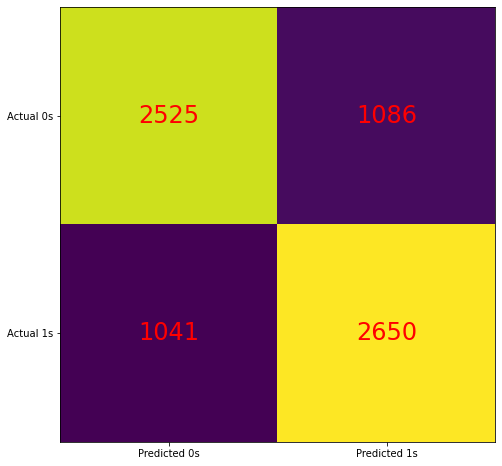

In [ ]:
cm = confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red',fontsize=24)
plt.show()

In [ ]:
print("Classification Report")
print(classification_report(y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.70      0.70      3611
           1       0.71      0.72      0.71      3691

    accuracy                           0.71      7302
   macro avg       0.71      0.71      0.71      7302
weighted avg       0.71      0.71      0.71      7302



In [ ]:
m_names = [
    'average_precision_score', 'brier_score_loss',
    'log_loss', 'roc_auc_score',
    'explained_variance_score', 'mean_absolute_error',
    'mean_squared_error', 'median_absolute_error', 'r2_score'
]

metrics = [average_precision_score, brier_score_loss, log_loss, roc_auc_score,
           explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score]
for n, m in zip(m_names, metrics):
    print('{:.5f} : {}'.format(m(y_test, predictions), n))

0.65183 : average_precision_score
0.29129 : brier_score_loss
10.06092 : log_loss
0.70861 : roc_auc_score
-0.16515 : explained_variance_score
0.29129 : mean_absolute_error
0.29129 : mean_squared_error
0.00000 : median_absolute_error
-0.16530 : r2_score


In [ ]:
# define the model
model = GradientBoostingClassifier()
# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
# evaluate the model on the dataset
n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Mean Accuracy: 0.702 (0.009)


In [ ]:
# define the model
model = GradientBoostingRegressor()
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model
n_scores = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# report performance
print('MSE: %.3f (%.3f)' % (-mean(n_scores), std(n_scores)))

MSE: 0.192 (0.002)


>10 0.678 (0.006)
>50 0.694 (0.006)
>100 0.702 (0.006)
>500 0.717 (0.006)


{'whiskers': [<matplotlib.lines.Line2D at 0x1e5dd61a160>,
 'caps': [<matplotlib.lines.Line2D at 0x1e5dd61a820>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e5dd608dc0>,
 'medians': [<matplotlib.lines.Line2D at 0x1e5dd61aee0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1e5dd6255e0>,
 'means': [<matplotlib.lines.Line2D at 0x1e5dd625280>,
  <matplotlib.lines.Line2D at 0x1e5dd5ce0d0>]}

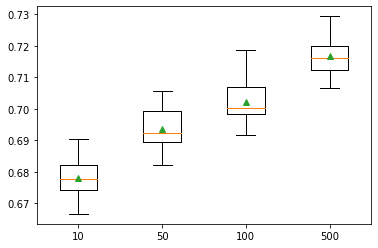

In [ ]:
# get a list of models to evaluate
list_score_tree=[0]*4
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500]
    for n in n_trees:
        models[str(n)] = GradientBoostingClassifier(n_estimators=n)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, x, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores
i=0
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, x, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    list_score_tree[i]=mean(scores)
    i+=1
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
#we can see that that performance improves on this dataset until about 500 trees, after which performance appears to stay same. Unlike AdaBoost, Gradient Boosting appears to not overfit as the number of trees is increased in this case.
#more trees is often better. The number of trees must also be balanced with the learning rate, e.g. more trees may require a smaller learning rate, fewer trees may require a larger learning rate.

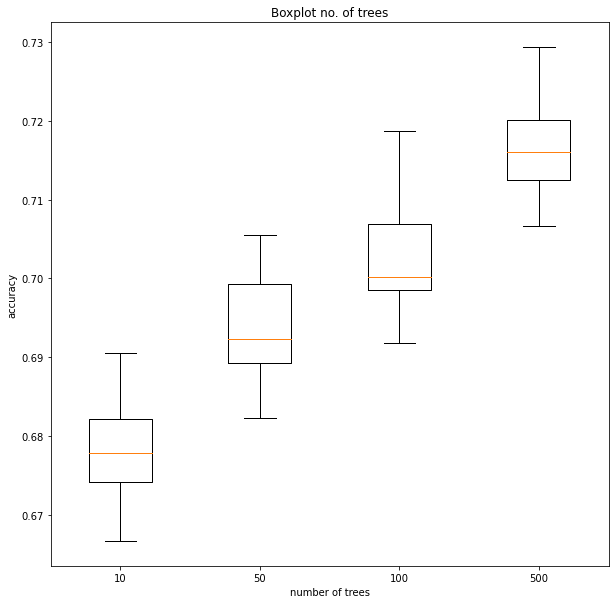

In [ ]:
plt.figure(figsize=(10, 10))
plt.boxplot(results, labels=names)
plt.title('Boxplot no. of trees')
plt.xlabel('number of trees')
plt.ylabel('accuracy')
plt.savefig("2.GBC-1.jpg",bbox_inches="tight")

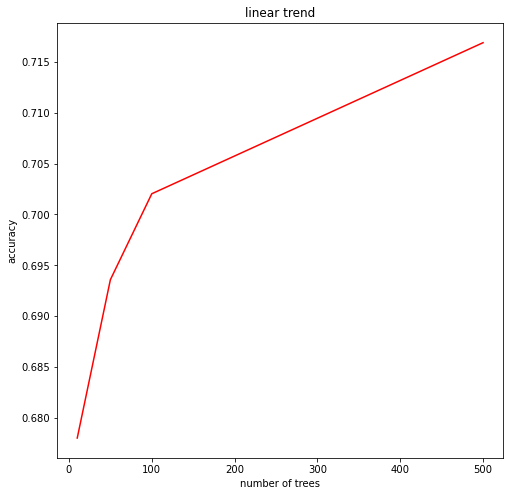

In [ ]:
plt.figure(figsize=(8, 8))
n_trees = [10, 50, 100, 500]
plt.plot(n_trees, list_score_tree, color="r")
plt.title('linear trend')
plt.xlabel('number of trees')
plt.ylabel('accuracy')
plt.savefig("2.GBC-2.jpg",bbox_inches="tight")

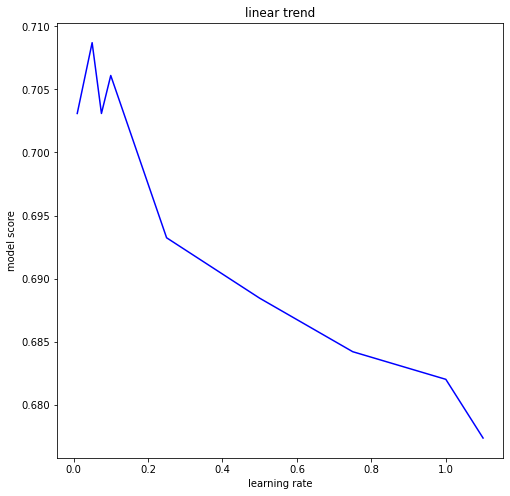

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(lr_list, model_gbc_acc, color="b")
plt.title('linear trend')
plt.xlabel('learning rate')
plt.ylabel('model score')
plt.savefig("2.GBC-3.jpg",bbox_inches="tight")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns; sns.set()
from sklearn import metrics
from sklearn.metrics import average_precision_score, brier_score_loss, \
    log_loss, roc_auc_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, \
    mean_squared_error, median_absolute_error, r2_score

In [ ]:
data = pd.read_csv("Balanced_Data_Undersampling.csv")

Time = pd.get_dummies(data.Time_Zone, prefix='Time_Zone')
Zone1 = pd.get_dummies(data.Zone, prefix='Zone')
Weather = pd.get_dummies(data.Weather_Condition, prefix='Weather_Condition')

data = data.join(Time)
data = data.join(Zone1)
data = data.join(Weather)

data.drop(['Time_Zone'], axis=1, inplace=True)
data.drop(['Zone'], axis=1, inplace=True)
data.drop(['Weather_Condition'], axis=1, inplace=True)

features= data.columns
x=data[features[1:]]
y=data.Severity

x_train, x_test, y_train, y_test =\
    train_test_split(x, y, test_size=0.2, random_state=0)

clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=14,
                                  random_state=0)

clf_tree.fit(x_train, y_train)
y_pred = clf_tree.predict(x_test)

In [ ]:
clf_tree.score(x_train,y_train)

0.7314592891871533

In [ ]:
clf_tree.score(x_test, y_test)

0.6841961106546152

In [ ]:
confusion_matrix(y_test, y_pred)

array([[2310, 1301],
       [1005, 2686]], dtype=int64)

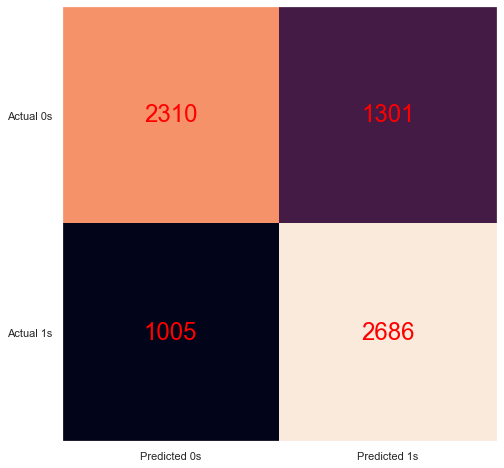

In [ ]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red',fontsize=24)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67      3611
           1       0.67      0.73      0.70      3691

    accuracy                           0.68      7302
   macro avg       0.69      0.68      0.68      7302
weighted avg       0.69      0.68      0.68      7302



In [ ]:
m_names = [
    'average_precision_score', 'brier_score_loss',
    'log_loss', 'roc_auc_score',
    'explained_variance_score', 'mean_absolute_error',
    'mean_squared_error', 'median_absolute_error', 'r2_score'
]
metrics = [average_precision_score, brier_score_loss, log_loss, roc_auc_score,
           explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score]
for n, m in zip(m_names, metrics):
    print('{:.5f} : {}'.format(m(y_test, y_pred), n))

0.62789 : average_precision_score
0.31580 : brier_score_loss
10.90762 : log_loss
0.68371 : roc_auc_score
-0.25679 : explained_variance_score
0.31580 : mean_absolute_error
0.31580 : mean_squared_error
0.00000 : median_absolute_error
-0.26337 : r2_score


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pandas as pd
from sklearn.metrics import average_precision_score, brier_score_loss, \
    log_loss, roc_auc_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, \
    mean_squared_error, median_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
data = pd.read_csv("Balanced_Data_Undersampling.csv")

Time = pd.get_dummies(data.Time_Zone, prefix='Time_Zone')
Zone1 = pd.get_dummies(data.Zone, prefix='Zone')
Weather = pd.get_dummies(data.Weather_Condition, prefix='Weather_Condition')

data = data.join(Time)
data = data.join(Zone1)
data = data.join(Weather)

data.drop(['Time_Zone'], axis=1, inplace=True)
data.drop(['Zone'], axis=1, inplace=True)
data.drop(['Weather_Condition'], axis=1, inplace=True)

features= data.columns
x=data[features[1:]]
y=data.Severity

x_train, x_test, y_train, y_test =\
    train_test_split(x, y, test_size=0.2, random_state=0)

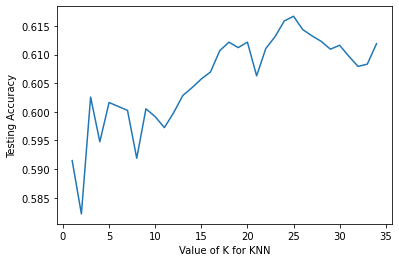

In [ ]:
k_range = range(1,35)
scores = {}
scores_list = []
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train,y_train)
        y_pred=knn.predict(x_test)
        scores[k] = metrics.accuracy_score(y_test,y_pred)
        scores_list.append(metrics.accuracy_score(y_test,y_pred))


#plot the relationship between K and the testing accuracy
plt.plot(k_range,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.savefig("KNN2.png",bbox_inches="tight")

In [ ]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=25)

In [ ]:
knn.score(x_train, y_train)

0.6481887283434911

In [ ]:
knn.score(x_test, y_test)

0.6166803615447822

In [ ]:
knn.score(x, y)

0.6418867097622439

In [ ]:
confusion_matrix(y_test, y_pred)

array([[2098, 1513],
       [1321, 2370]], dtype=int64)

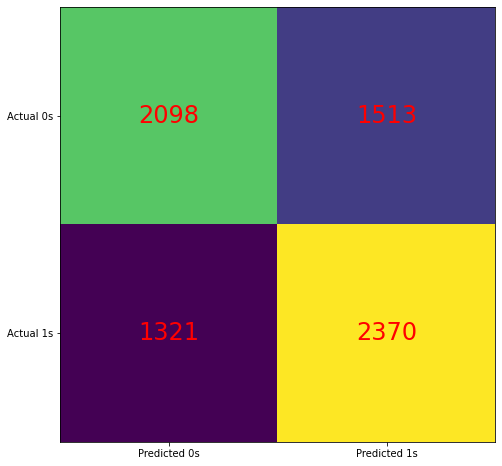

In [ ]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red',fontsize=24)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.58      0.60      3611
           1       0.61      0.64      0.63      3691

    accuracy                           0.61      7302
   macro avg       0.61      0.61      0.61      7302
weighted avg       0.61      0.61      0.61      7302



In [ ]:
m_names = [
    'average_precision_score', 'brier_score_loss',
    'log_loss', 'roc_auc_score',
    'explained_variance_score', 'mean_absolute_error',
    'mean_squared_error', 'median_absolute_error', 'r2_score'
]
metrics = [average_precision_score, brier_score_loss, log_loss, roc_auc_score,
           explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score]
for n, m in zip(m_names, metrics):
    print('{:.5f} : {}'.format(m(y_test, y_pred), n))

0.57282 : average_precision_score
0.38811 : brier_score_loss
13.40511 : log_loss
0.61155 : roc_auc_score
-0.54987 : explained_variance_score
0.38811 : mean_absolute_error
0.38811 : mean_squared_error
0.00000 : median_absolute_error
-0.55264 : r2_score


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, brier_score_loss, \
    log_loss, roc_auc_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, \
    mean_squared_error, median_absolute_error, r2_score
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
data = pd.read_csv("Balanced_Data_Undersampling.csv")

Time = pd.get_dummies(data.Time_Zone, prefix='Time_Zone')
Zone1 = pd.get_dummies(data.Zone, prefix='Zone')
Weather = pd.get_dummies(data.Weather_Condition, prefix='Weather_Condition')

data = data.join(Time)
data = data.join(Zone1)
data = data.join(Weather)

data.drop(['Time_Zone'], axis=1, inplace=True)
data.drop(['Zone'], axis=1, inplace=True)
data.drop(['Weather_Condition'], axis=1, inplace=True)

features= data.columns
x=data[features[1:]]
y=data.Severity

x_train, x_test, y_train, y_test =\
    train_test_split(x, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

model = LogisticRegression(solver='newton-cg', C=0.05, multi_class='ovr',
                           random_state=0)
model.fit(x_train, y_train)

x_test = scaler.transform(x_test)

y_pred = model.predict(x_test)

In [ ]:
model.score(x_train, y_train)

0.6987605286584948

In [ ]:
model.score(x_test, y_test)

0.6970692960832648

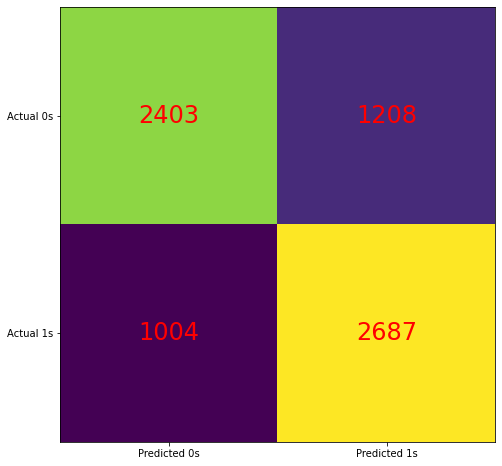

In [ ]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red',fontsize=24)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.67      0.68      3611
           1       0.69      0.73      0.71      3691

    accuracy                           0.70      7302
   macro avg       0.70      0.70      0.70      7302
weighted avg       0.70      0.70      0.70      7302



In [ ]:
m_names = [
    'average_precision_score', 'brier_score_loss',
    'log_loss', 'roc_auc_score',
    'explained_variance_score', 'mean_absolute_error',
    'mean_squared_error', 'median_absolute_error', 'r2_score'
]
metrics = [average_precision_score, brier_score_loss, log_loss, roc_auc_score,
           explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score]
for n, m in zip(m_names, metrics):
    print('{:.5f} : {}'.format(m(y_test, y_pred), n))

0.63970 : average_precision_score
0.30293 : brier_score_loss
10.46299 : log_loss
0.69673 : roc_auc_score
-0.20875 : explained_variance_score
0.30293 : mean_absolute_error
0.30293 : mean_squared_error
0.00000 : median_absolute_error
-0.21187 : r2_score


In [ ]:
def efron_rsquare(y_test, y_pred):
    n = float(len(y_test))
    t1 = np.sum(np.power(y_test - y_pred, 2.0))
    t2 = np.sum(np.power((y_test - (np.sum(y_test) / n)), 2.0))
    return 1.0 - (t1 / t2)

efron_rsquare(y_test, y_pred)

-0.21186827839706157

In [ ]:
def mz_rsquare(y_pred):
    return np.var(y_pred) / (np.var(y_pred) + (np.power(np.pi, 2.0) / 3.0) )
mz_rsquare(y_pred)

0.0703308501660993

In [ ]:
def get_num_correct(y_test, y_pred, t=0.5):
    y_correct = np.array([0.0 if p < t else 1.0 for p in y_pred])
    return sum([1.0 for p, p_pred in zip(y_test, y_correct) if p == p_pred])
def get_count_most_freq_outcome(y):
    num_0 = 0
    num_1 = 0
    for p in y:
        if p == 1.0:
            num_1 += 1
        else:
            num_0 += 1
    return float(max(num_0, num_1))

def count_adjusted_rsquare(y_test, y_pred, t=0.5):
    correct = get_num_correct(y_test, y_pred, t)
    total = float(len(y_test))
    n = get_count_most_freq_outcome(y_test)
    return (correct - n) / (total - n)

count_adjusted_rsquare(y_test, y_pred)

0.3874273054555525

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.768


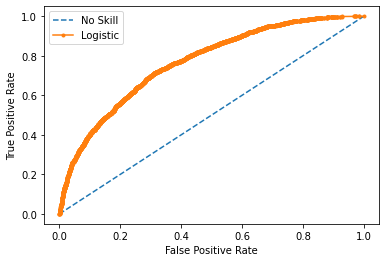

In [ ]:
# roc curve and auc
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(x_train, y_train)
# predict probabilities
lr_probs = model.predict_proba(x_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
def roc(x_train2, x_test2, y_train2, y_test2):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test2))]
    # fit a model
    model = LogisticRegression(solver='lbfgs')
    model.fit(x_train2, y_train2)
    # predict probabilities
    lr_probs = model.predict_proba(x_test2)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test2, ns_probs)
    lr_auc = roc_auc_score(y_test2, lr_probs)
    return lr_auc

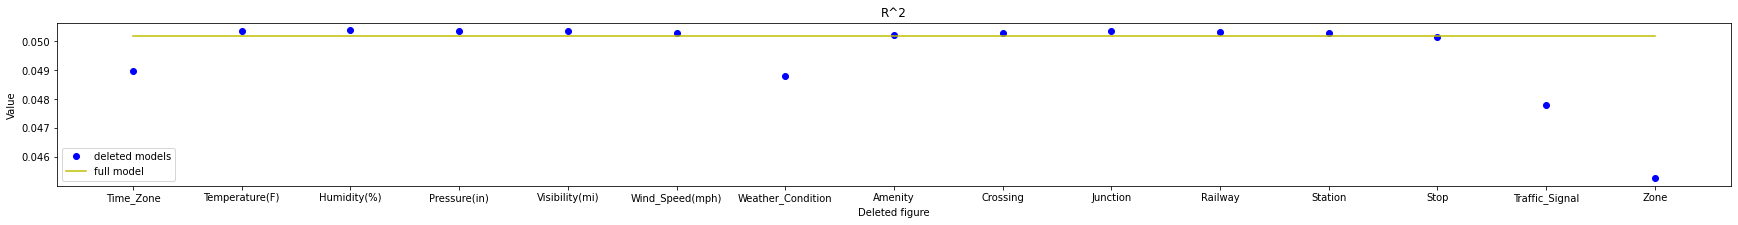

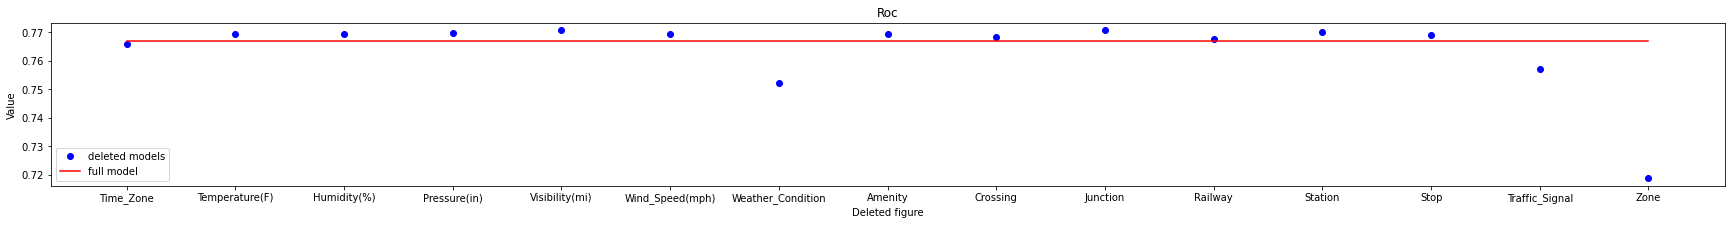

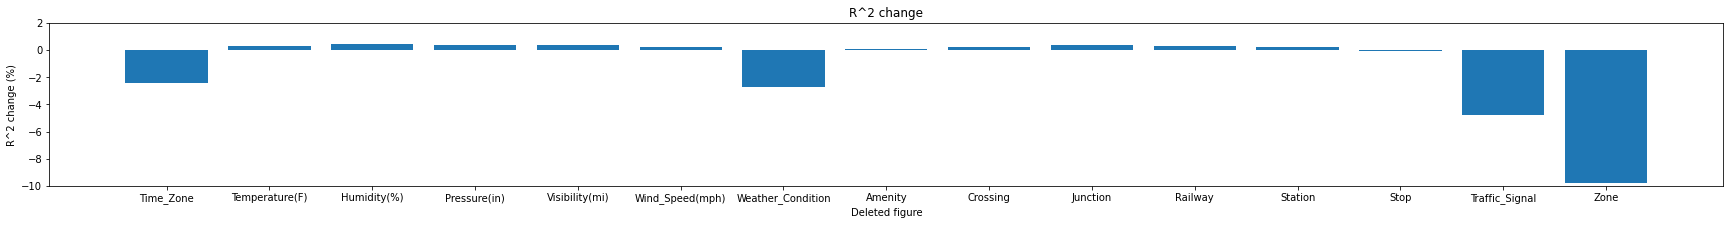

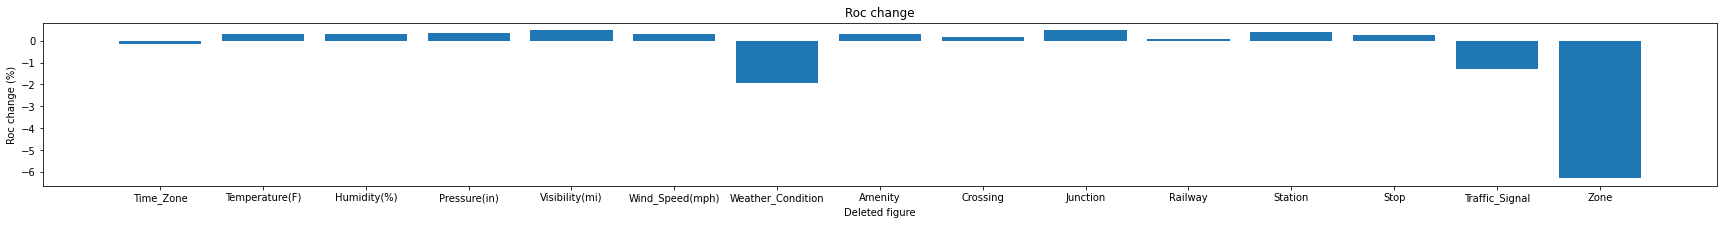

In [ ]:
score2_figure_list=list()
score_figure_list=list()
line=[0.05017269237231213]*15
line2=[0.767]*15
list_change_r2=[0]*15
list_change_roc=[0]*15
data2 = pd.read_csv("Processed-Data.csv")
y2=data2.Severity
x2=data2.drop(columns="Severity")
for i in list(x2):
    temp_table=x2.drop([i],inplace=False,axis=1)
    if i!="Time_Zone":
        Time = pd.get_dummies(temp_table.Time_Zone, prefix='Time_Zone')
        temp_table = temp_table.join(Time)
        temp_table.drop(['Time_Zone'], axis=1, inplace=True)
    if i!="Weather_Condition":
        Weather = pd.get_dummies(temp_table.Weather_Condition, prefix='Weather_Condition')
        temp_table = temp_table.join(Weather)
        temp_table.drop(['Weather_Condition'], axis=1, inplace=True)
    if i!="Zone":
        Zone1 = pd.get_dummies(temp_table.Zone, prefix='Zone')
        temp_table = temp_table.join(Zone1)
        temp_table.drop(['Zone'], axis=1, inplace=True)
    #train model
    x_train2, x_test2, y_train2, y_test2 =\
    train_test_split(temp_table, y2, test_size=0.2, random_state=0)

    scaler = StandardScaler()
    x_train2 = scaler.fit_transform(x_train2)

    model = LogisticRegression(solver='newton-cg', C=0.05, multi_class='ovr',
                               random_state=0)
    model.fit(x_train2, y_train2)

    x_test2 = scaler.transform(x_test2)

    y_pred2 = model.predict(x_test2)
#roc va mz_R^2
    score_figure_list.append(mz_rsquare(y_pred2))
    score2_figure_list.append(roc(x_train2, x_test2, y_train2, y_test2))
plt.figure(figsize=(30, 3))
plt.plot(list(x2), score_figure_list, 'bo',label='deleted models')
plt.plot(list(x2), line, 'y',label="full model")
plt.legend()
plt.title('R^2')
plt.xlabel('Deleted figure')
plt.ylabel('Value')
plt.savefig("LR2-R^2.jpg",bbox_inches="tight")
plt.figure(figsize=(30, 3))
plt.plot(list(x2), score2_figure_list,'bo',label='deleted models')
plt.plot(list(x2), line2,'r',label="full model")
plt.legend()

plt.title('Roc')
plt.xlabel('Deleted figure')
plt.ylabel('Value')

plt.savefig("LR2-Roc.jpg",bbox_inches="tight")

for i in range(15):
    list_change_r2[i]=100.0*(score_figure_list[i]-line[i])/line[i]
    list_change_roc[i]=100.0*(score2_figure_list[i]-line2[i])/line2[i]

cnum=np.arange(15)
plt.figure(figsize=(30, 3))
plt.bar(cnum,list_change_r2)
ticks=plt.xticks(cnum,list(x2))
plt.title('R^2 change')
plt.xlabel('Deleted figure')
plt.ylabel('R^2 change (%)')
plt.savefig("LR2-R^2 change.jpg",bbox_inches="tight")
ax=plt.gca()
ax.set_ylim([-10,2])
plt.figure(figsize=(30, 3))
plt.bar(cnum,list_change_roc)
ticks=plt.xticks(cnum,list(x2))
plt.title('Roc change')
plt.xlabel('Deleted figure')
plt.ylabel('Roc change (%)')
plt.savefig("LR2-Roc change.jpg",bbox_inches="tight")


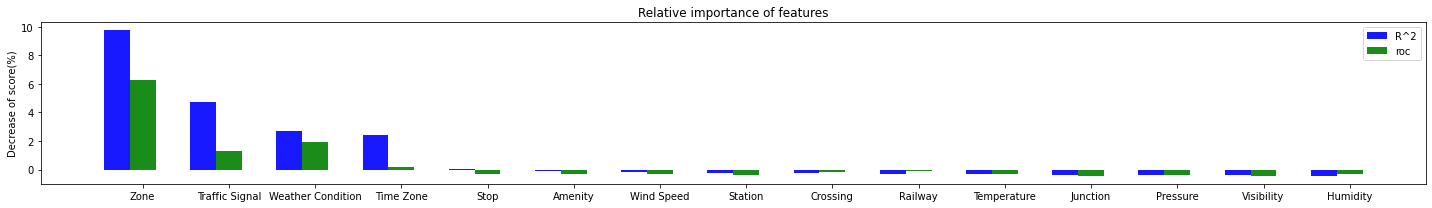

In [ ]:
n_groups = 15
list2_change_r2 = [-i for i in list_change_r2]
list2_change_roc = [-j for j in list_change_roc]

zip1 = zip(x2, list2_change_r2)
zip2 = zip(x2, list2_change_roc)
dct = dict(list(zip1))
dct1 = dict(list(zip2))
dct = dict(sorted(dct.items(), key=lambda x: x[1], reverse=True))
features = dct.keys()
ls_r2 = dct.values()
ls_roc = list()
for i in features:
    ls_roc.append(dct1[i])
ls_r2 = tuple(ls_r2)
ls_roc = tuple(ls_roc)

clmn = ("Zone", 'Traffic Signal', 'Weather Condition', 'Time Zone', 'Stop', 'Amenity', 'Wind Speed', 'Station',
        'Crossing', 'Railway', 'Temperature', 'Junction', 'Pressure', 'Visibility', 'Humidity')
plt.figure(figsize=(20, 3))

# create plot
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.9
rects1 = plt.bar(index, ls_r2, bar_width,alpha=opacity,color='b',label='R^2')
rects2 = plt.bar(index + bar_width, ls_roc, bar_width,alpha=opacity,color='g',label='roc')

plt.ylabel('Decrease of score(%)')
plt.title('Relative importance of features')

plt.xticks(index + bar_width, clmn)
plt.legend()

plt.tight_layout()
plt.show()